In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Tue Aug 12 06:01:36 PDT 2025
lutzes
/mnt/share/homes/lutzes/vivarium_research_alzheimers/verification_and_validation


## V&V List from Docs 
- Check whether overall population remains stable over time
- Validate Alzheimer’s prevalence against GBD
- Check whether Alzheimer’s prevalence remains stable over time
- Verify Alzheimer’s incidence rate against GBD
- Verify ACMR against GBD
- Validate Alzheimer’s CSMR against GBD
- Validate Alzheimer’s EMR against GBD
- Validate Alzheimer’s YLLs and YLDs against GBD
- For comparison with model 2, calculate total “real world” Alzheimer’s population over time 

# Load Data

In [2]:
locations = ['united_states_of_america', 'china']

results_dir_prefix = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

results_dirs = [
    results_dir_prefix + 'results/model1.0/united_states_of_america/2025_08_04_12_16_36/results/',
    results_dir_prefix + 'results/model1.0/china/2025_08_04_13_18_19/results/'
]

artifact_dirs = [results_dir_prefix + 'artifacts/model1.0/' + x + '.hdf' for x in locations]
artifact_dirs

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model1.0/united_states_of_america.hdf',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model1.0/china.hdf']

In [3]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['deaths.parquet',
 'ylls.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'ylds.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet']

In [4]:
draws = pd.read_parquet(results_dirs[0]+'deaths.parquet')
draws = list(draws.input_draw.unique())
draw_cols = [f'draw_{c}' for c in draws]
draw_cols

['draw_480',
 'draw_457',
 'draw_273',
 'draw_323',
 'draw_169',
 'draw_446',
 'draw_392',
 'draw_346',
 'draw_258',
 'draw_356']

In [5]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0], filter_terms = ['year_start==2021'])

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end
age_dictionary.head()

,age_group_id,age_group_name,age_group,age_start,age_end
0,11,30 to 34,30_to_34,30.0,35.0
1,12,35 to 39,35_to_39,35.0,40.0
2,13,40 to 44,40_to_44,40.0,45.0
3,14,45 to 49,45_to_49,45.0,50.0
4,15,50 to 54,50_to_54,50.0,55.0


## Check whether overall population remains stable over time

In [6]:
def load_df(measure):
    data = pd.DataFrame()
    for results_dir in results_dirs:
        temp = pd.read_parquet(results_dir + measure + '.parquet')
        temp['location'] = locations[results_dirs.index(results_dir)].title()
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [7]:
cols = ['input_draw','current_year','location'] #, 'age_group']

person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total.head()

,current_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,China,10.0,298933.343190,98.015328,298849.730322,298850.739357,298879.876797,299099.123888,299110.335387
1,2025,United_States_Of_America,10.0,299113.673922,45.660499,299073.960301,299074.072416,299102.611910,299200.899384,299210.989733
2,2026,China,10.0,199147.763450,239.517178,198883.022587,198900.512526,199040.980151,199569.166324,199609.527721
3,2026,United_States_Of_America,10.0,199571.508282,70.769511,199479.972621,199485.466256,199559.200548,199679.026557,199682.277892
4,2027,China,10.0,198975.305681,348.018744,198651.318275,198656.475565,198808.279261,199559.698836,199600.060233


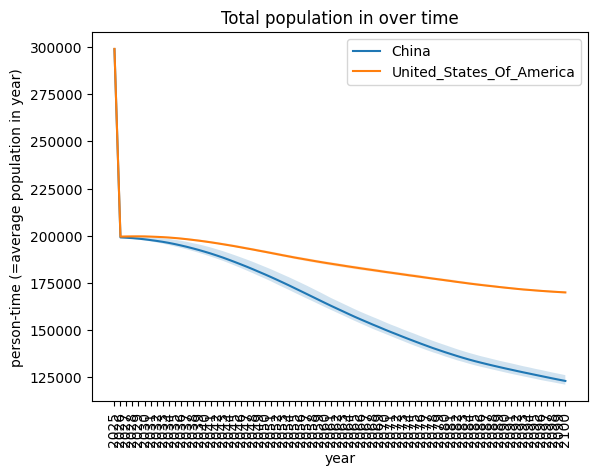

In [8]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.current_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Total population in over time")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("person-time (=average population in year)")
    plt.legend()

for location in person_time_total.location.unique():
    for age in person_time_total.age_group.unique():
        plot_data = person_time_total.loc[(person_time_total.location == location) & (person_time_total.age_group == age)]
        plt.plot(plot_data.current_year, plot_data['mean'], label=location)
        plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
        plt.title(f"Total population in {age} over time")
        plt.tick_params(axis='x', labelrotation=90)
        plt.xlabel("year")
        plt.ylabel("person-time (=average population in year)")
        plt.legend()
        plt.figure()

It does not remain stable over time, but I do not think there is an issue. When the above code is printed, the older age groups are increasing over while younger age groups decrease. The mean age in the sim is getting older. 

As the average age is older, more people die (higher average mortality) while fertility is unchanging. This leads to population decreases over time. See the below stable ACMR by age group. 

## Validate Alzheimer’s prevalence against the artifact 
## Check whether Alzheimer’s prevalence remains stable over time

In [ ]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_prevalence():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[person_time_total.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()

    total = person_time_total.groupby(cols).sum()

    prev = (infected / total)[['value']].reset_index()
    prev = prev.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    prev = prev.merge(age_dictionary, on=['age_group'])
    prev = prev.loc[prev['age_group_id'].isin(age_group_ids)]
    return prev

sim_prev = calculate_prevalence()

/tmp/ipykernel_2949677/593725008.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  infected = person_time_total.loc[person_time_total.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()
/tmp/ipykernel_2949677/593725008.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total = person_time_total.groupby(cols).sum()


In [10]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
        data = art.load(f'cause.alzheimers_disease_and_other_dementias.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out
art_prev = load_artifact_cause_data('prevalence')

In [11]:
def age_group_plot(measure, sim_data, art_data):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.current_year == '2025') & (sim_data.sex == sex)]
            art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex)]

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {sex}')
            plt.fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} in 2025")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

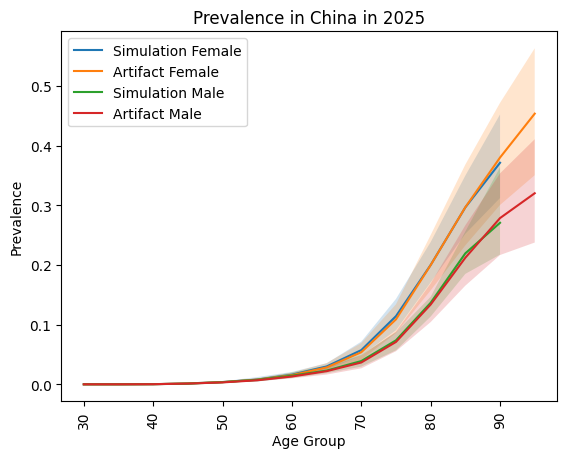

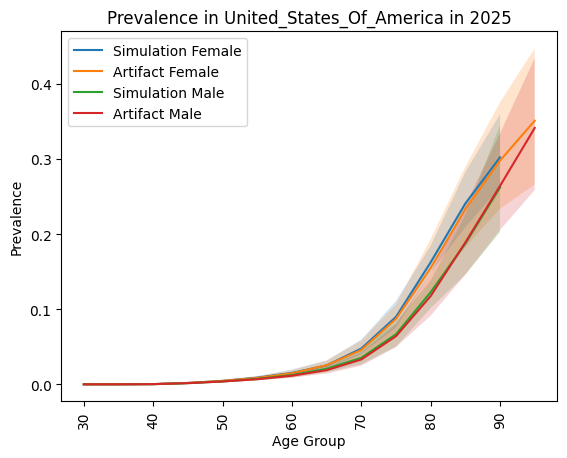

<Figure size 640x480 with 0 Axes>

In [12]:
age_group_plot('Prevalence', sim_prev, art_prev)

In [13]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.current_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among {age_start}-60 year olds")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

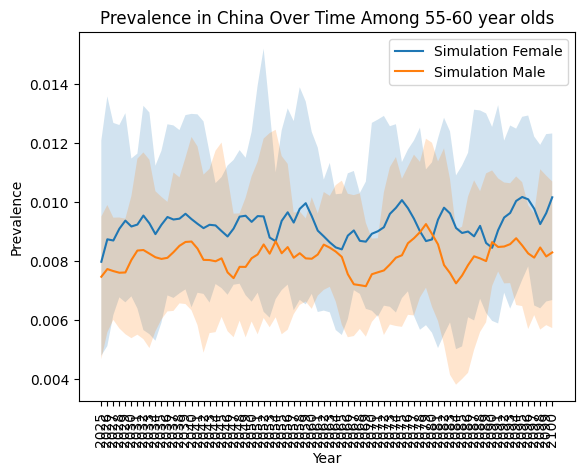

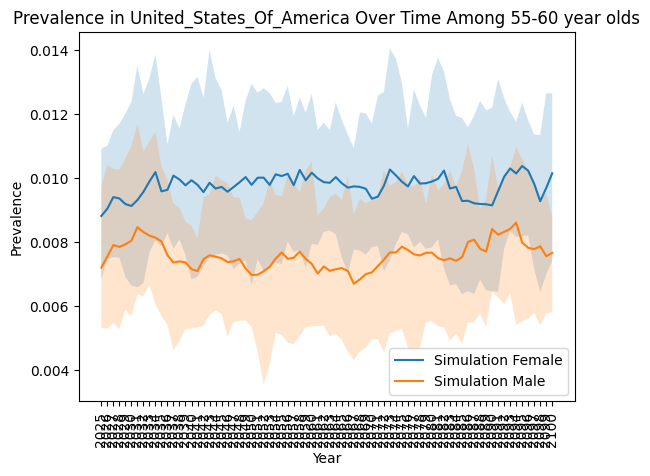

<Figure size 640x480 with 0 Axes>

In [14]:
over_time_plot('Prevalence', sim_prev, 55)

Note: I checked a few age buckets but didn't print all of them to save space. All looked good! 

## Verify Alzheimer’s incidence rate against artifact

In [15]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_incidence():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    susceptible = person_time_total.loc[person_time_total.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].groupby(cols).sum()

    transitions = load_df('transition_count_alzheimers_disease_and_other_dementias')
    transitions = transitions.loc[transitions.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].groupby(cols).sum()

    inc = (transitions / susceptible)[['value']].reset_index()
    inc['value'] = inc['value'].replace([np.inf, -np.inf], 0)

    inc = inc.merge(age_dictionary, on=['age_group'])
    inc = inc.loc[inc['age_group_id'].isin(age_group_ids)]
    inc = inc.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return inc

sim_inc = calculate_incidence()

/tmp/ipykernel_2949677/3978289674.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  susceptible = person_time_total.loc[person_time_total.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].groupby(cols).sum()
/tmp/ipykernel_2949677/3978289674.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  transitions = transitions.loc[transitions.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].groupby(cols).sum()


In [16]:
art_inc = load_artifact_cause_data('incidence_rate')
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age_group_id,age_group_name,age_group,measure,location
0,Female,30.0,35.0,2021,2022,0.000000,0.000000,0.000000,11,30 to 34,30_to_34,incidence_rate,United_States_Of_America
1,Male,30.0,35.0,2021,2022,0.000000,0.000000,0.000000,11,30 to 34,30_to_34,incidence_rate,United_States_Of_America
2,Female,35.0,40.0,2021,2022,0.000000,0.000000,0.000000,12,35 to 39,35_to_39,incidence_rate,United_States_Of_America
3,Male,35.0,40.0,2021,2022,0.000000,0.000000,0.000000,12,35 to 39,35_to_39,incidence_rate,United_States_Of_America
4,Female,40.0,45.0,2021,2022,0.000146,0.000067,0.000245,13,40 to 44,40_to_44,incidence_rate,United_States_Of_America


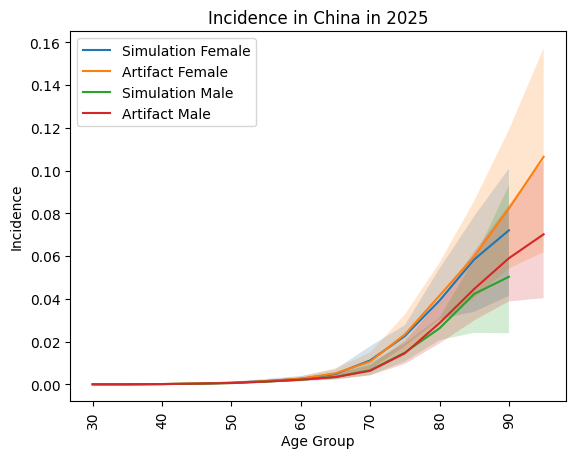

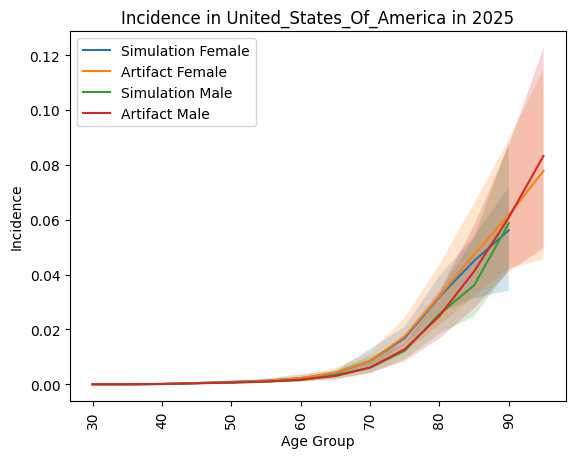

<Figure size 640x480 with 0 Axes>

In [17]:
age_group_plot('Incidence', sim_inc, art_inc)

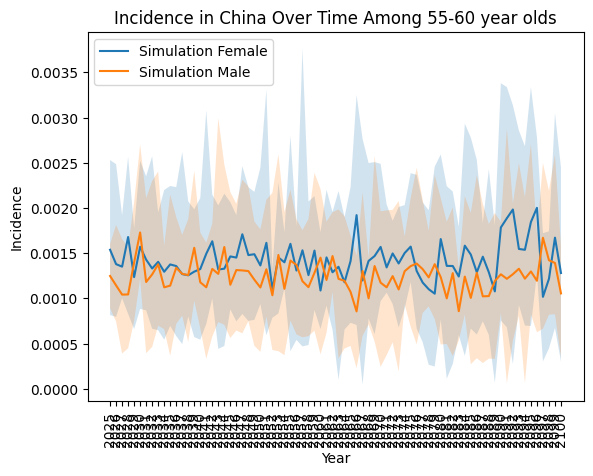

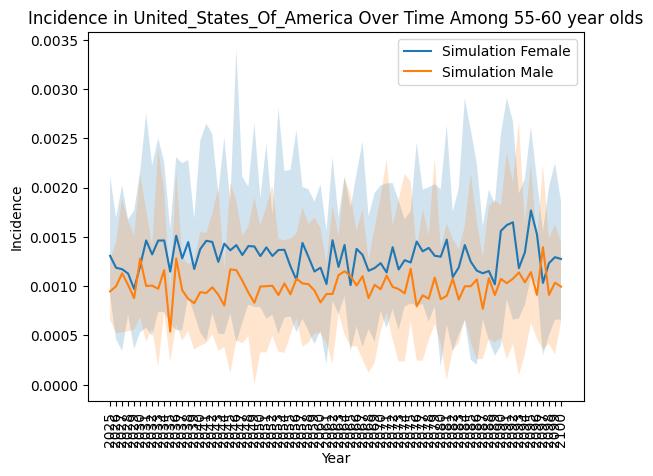

<Figure size 640x480 with 0 Axes>

In [18]:
over_time_plot('Incidence', sim_inc, 55)

## Verify ACMR against artifact

In [19]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_acmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum()

    deaths = load_df('deaths')
    deaths = deaths.groupby(cols).sum()

    acmr = (deaths / total_pt)[['value']].reset_index()

    acmr = acmr.merge(age_dictionary, on=['age_group'])
    acmr = acmr.loc[acmr['age_group_id'].isin(age_group_ids)]
    acmr = acmr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return acmr

sim_acmr = calculate_acmr()

/tmp/ipykernel_2949677/3885451193.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_pt = person_time_total.groupby(cols).sum()
/tmp/ipykernel_2949677/3885451193.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deaths = deaths.groupby(cols).sum()


In [20]:
art_acmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
    data = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data = data.merge(age_dictionary, on=['age_start','age_end'])
    data = data.loc[data['age_group_id'].isin(age_group_ids)]
    data['measure'] = 'acmr'
    data['location'] = locations[artifact_dirs.index(artifact_dir)].title()
    art_acmr = pd.concat([art_acmr, data])
#art_acmr.head()

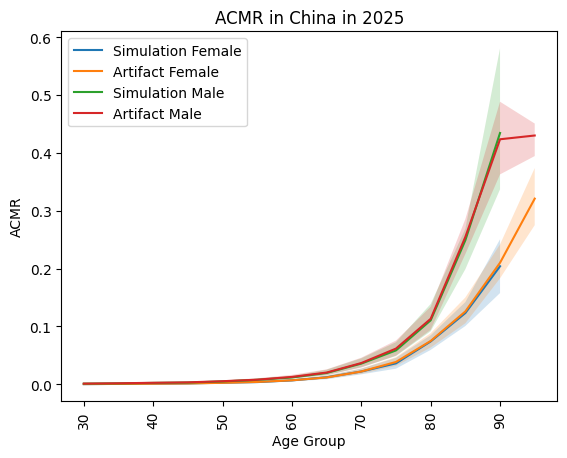

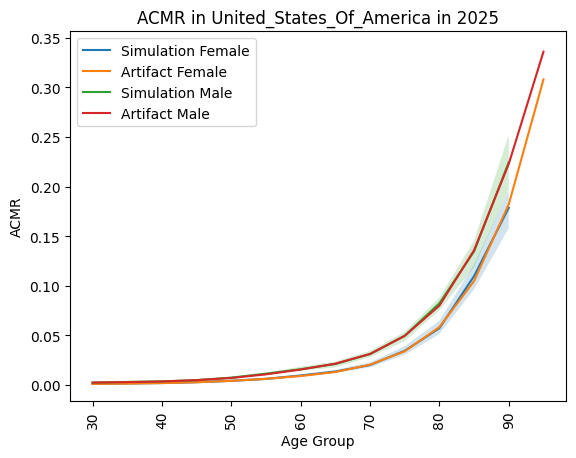

<Figure size 640x480 with 0 Axes>

In [21]:
age_group_plot('ACMR', sim_acmr, art_acmr)

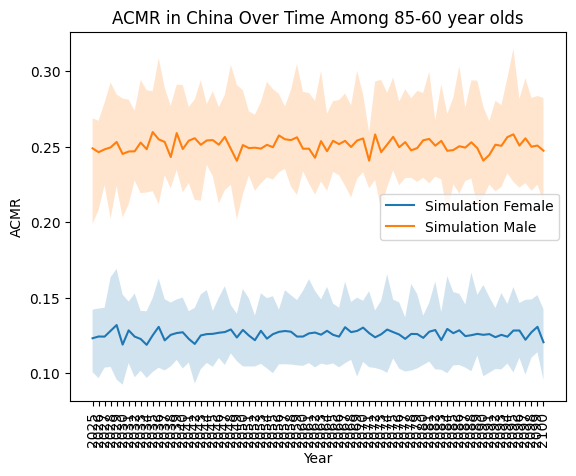

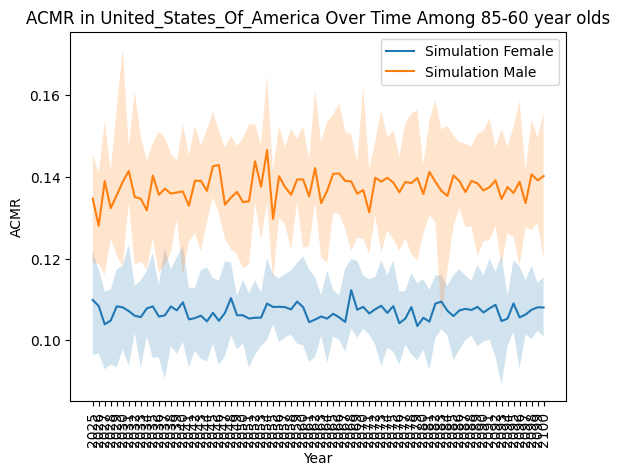

<Figure size 640x480 with 0 Axes>

In [22]:
over_time_plot('ACMR', sim_acmr, 85)

## Validate Alzheimer’s CSMR against artifact

In [23]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_csmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum()

    deaths = load_df('deaths')
    deaths = deaths.loc[deaths.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()

    acmr = (deaths / total_pt)[['value']].reset_index()

    acmr = acmr.merge(age_dictionary, on=['age_group'])
    acmr = acmr.loc[acmr['age_group_id'].isin(age_group_ids)]
    acmr = acmr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return acmr

sim_csmr = calculate_csmr()

/tmp/ipykernel_2949677/3981298958.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_pt = person_time_total.groupby(cols).sum()
/tmp/ipykernel_2949677/3981298958.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deaths = deaths.loc[deaths.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()


In [24]:
art_csmr = load_artifact_cause_data('cause_specific_mortality_rate')
#art_csmr.head()

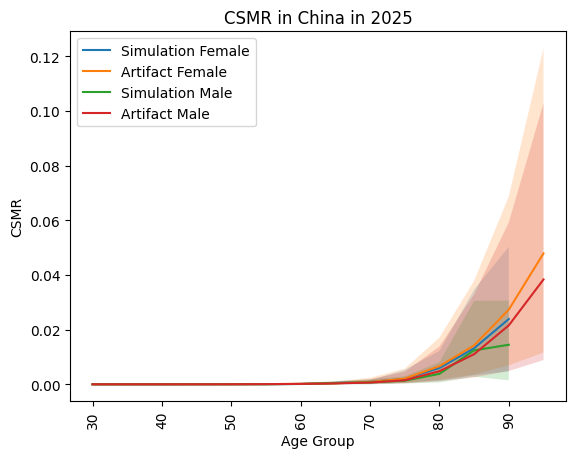

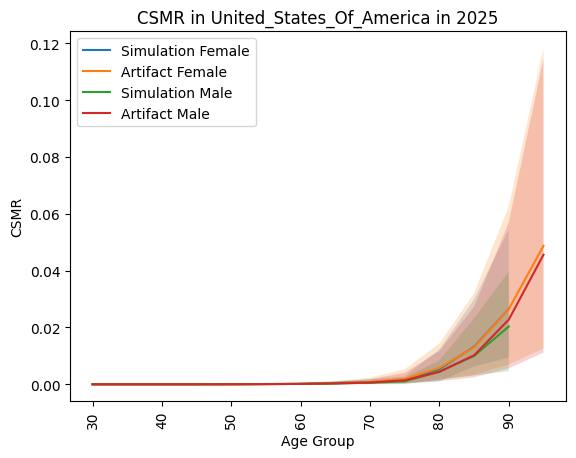

<Figure size 640x480 with 0 Axes>

In [25]:
age_group_plot('CSMR', sim_csmr, art_csmr)

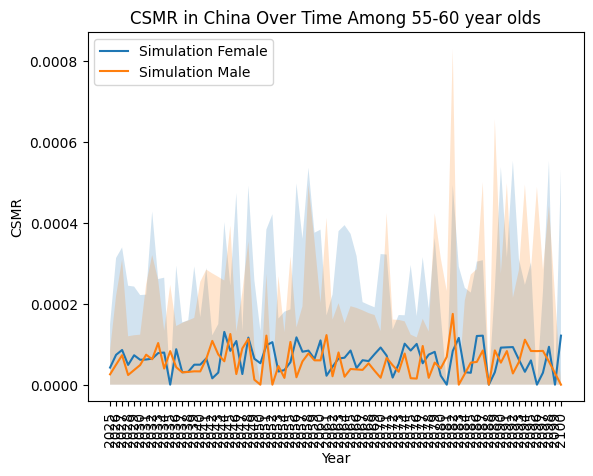

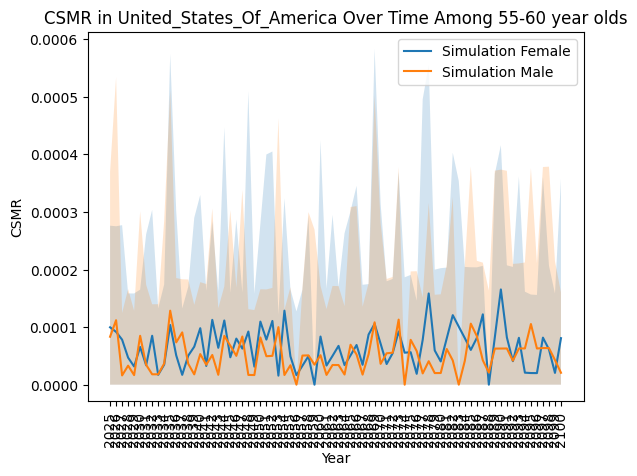

<Figure size 640x480 with 0 Axes>

In [26]:
over_time_plot('CSMR', sim_csmr, 55)

## Validate Alzheimer’s EMR against artifact

In [27]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_emr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[person_time_total.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()

    deaths = load_df('deaths')
    deaths = deaths.loc[deaths.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()

    acmr = (deaths / infected)[['value']].reset_index()

    acmr = acmr.merge(age_dictionary, on=['age_group'])
    acmr = acmr.loc[acmr['age_group_id'].isin(age_group_ids)]
    acmr = acmr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return acmr

sim_emr = calculate_emr()

/tmp/ipykernel_2949677/82446670.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  infected = person_time_total.loc[person_time_total.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()
/tmp/ipykernel_2949677/82446670.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deaths = deaths.loc[deaths.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()


In [28]:
art_emr = load_artifact_cause_data('excess_mortality_rate')
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age_group_id,age_group_name,age_group,measure,location
0,Female,30.0,35.0,2021,2022,0.000000,0.000000,0.000000,11,30 to 34,30_to_34,excess_mortality_rate,United_States_Of_America
1,Male,30.0,35.0,2021,2022,0.000000,0.000000,0.000000,11,30 to 34,30_to_34,excess_mortality_rate,United_States_Of_America
2,Female,35.0,40.0,2021,2022,0.000000,0.000000,0.000000,12,35 to 39,35_to_39,excess_mortality_rate,United_States_Of_America
3,Male,35.0,40.0,2021,2022,0.000000,0.000000,0.000000,12,35 to 39,35_to_39,excess_mortality_rate,United_States_Of_America
4,Female,40.0,45.0,2021,2022,0.001486,0.000113,0.005943,13,40 to 44,40_to_44,excess_mortality_rate,United_States_Of_America


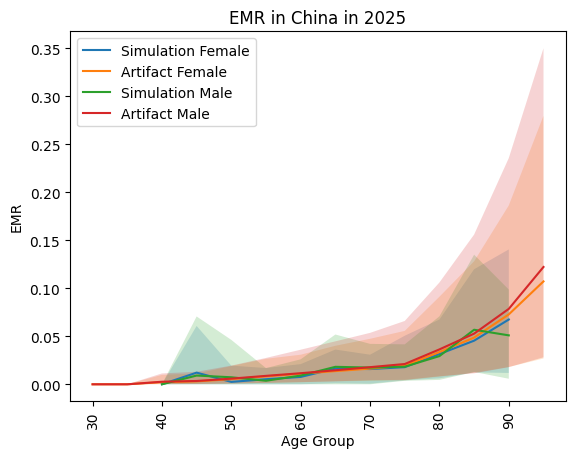

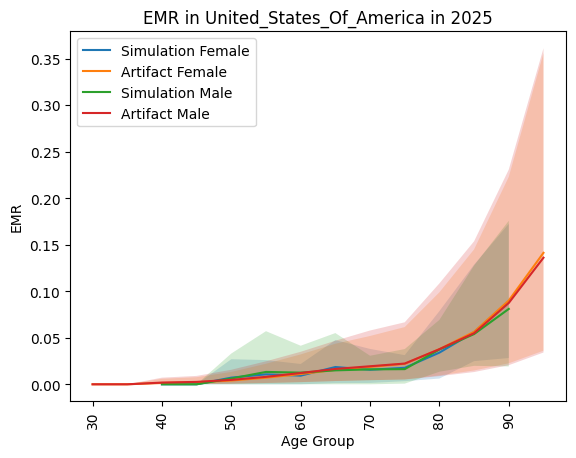

<Figure size 640x480 with 0 Axes>

In [29]:
age_group_plot('EMR', sim_emr, art_emr)

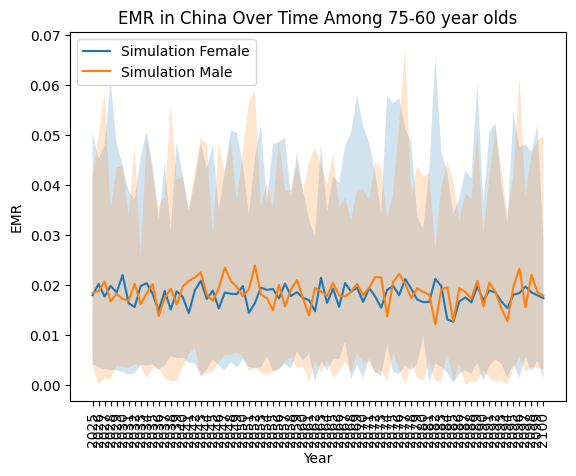

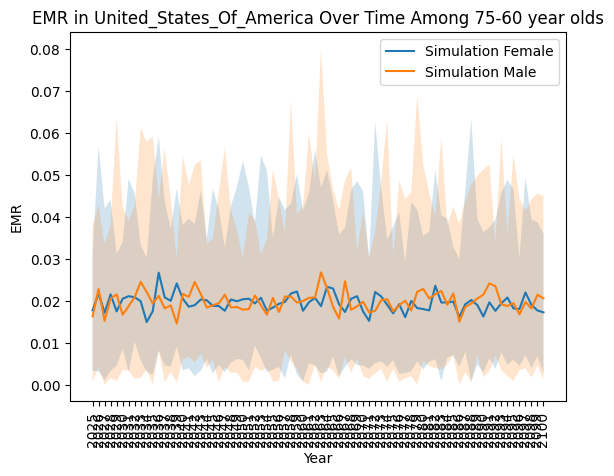

<Figure size 640x480 with 0 Axes>

In [30]:
over_time_plot('EMR', sim_emr, 75)

## Validate Alzheimer’s YLLs and YLDs against GBD

In [66]:
sex_ids = [1,2]
location_ids = [6,102]

gbd_data = get_outputs(topic='cause',
                      year_id=2021,
                      sex_id=sex_ids,
                      age_group_id=age_group_ids,
                      location_id=location_ids,
                      cause_id=543,
                      measure_id=[3,4],
                      metric_id=3,
                      release_id=9)
gbd_data['measure'] = gbd_data.measure_name.str.split(' ', expand=True)[0].str.lower()
gbd_data['location_name'] = gbd_data.location_name.str.replace(' ', '_').str.title()
gbd_data = gbd_data.merge(age_dictionary, on=['age_group_id','age_group_name'])
gbd_data.head()

/ihme/homes/lutzes/.conda/envs/mncnh_vv/lib/python3.11/site-packages/ihme_cc_rules_client/lib/rules_manager.py:167: UnrecognizedRuleWarning: Rules API returned unrecognized rule: COD_PASS_GET_RESULTS_TO_GET_ESTIMATES. The installed ihme_cc_rules_client package (version 4.0.2) is likely outdated and should be upgraded. If you see this warning in a central environment, please submit a Help Desk ticket for Central Comp: https://helpdesk.ihme.washington.edu
  warnings.warn(


,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure,measure_name,metric_name,sex,val,upper,lower,age_group,age_start,age_end
0,11,543,102,3,3,1,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,False,United_States_Of_America,admin0,ylds,YLDs (Years Lived with Disability),Rate,Male,0.0,0.0,0.0,30_to_34,30.0,35.0
1,11,543,102,3,3,2,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,False,United_States_Of_America,admin0,ylds,YLDs (Years Lived with Disability),Rate,Female,0.0,0.0,0.0,30_to_34,30.0,35.0
2,11,543,102,4,3,1,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,NaN,United_States_Of_America,admin0,ylls,YLLs (Years of Life Lost),Rate,Male,NaN,NaN,NaN,30_to_34,30.0,35.0
3,11,543,102,4,3,2,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,NaN,United_States_Of_America,admin0,ylls,YLLs (Years of Life Lost),Rate,Female,NaN,NaN,NaN,30_to_34,30.0,35.0
4,11,543,6,3,3,1,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,False,China,admin0,ylds,YLDs (Years Lived with Disability),Rate,Male,0.0,0.0,0.0,30_to_34,30.0,35.0


In [57]:
cols = ['input_draw','current_year','location','age_group','sex','measure']

def calculate_ylls_ylds():
    ylls = load_df('ylls')
    ylls = ylls.loc[ylls.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()#['value'].reset_index()

    ylds = load_df('ylds')
    ylds = ylds.loc[ylds.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()#['value'].reset_index()

    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby([c for c in cols if c != 'measure']).sum()

    ylls = (ylls / total_pt)[['value']].reset_index()
    ylds = (ylds / total_pt)[['value']].reset_index()

    combine = pd.concat([ylls, ylds], ignore_index=True)
    combine = combine.merge(age_dictionary, on=['age_group'])
    combine = combine.loc[combine['age_group_id'].isin(age_group_ids)]
    combine = combine.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return combine

sim_yll_yld = calculate_ylls_ylds()

/tmp/ipykernel_2949677/4064126926.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ylls = ylls.loc[ylls.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()#['value'].reset_index()
/tmp/ipykernel_2949677/4064126926.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ylds = ylds.loc[ylds.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols).sum()#['value'].reset_index()
/tmp/ipykernel_2949677/4064126926.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify n

In [58]:
sim_yll_yld.head()

,current_year,location,age_group,sex,measure,age_start,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,China,30_to_34,Female,ylds,30.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025,China,30_to_34,Female,ylls,30.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025,China,30_to_34,Male,ylds,30.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2025,China,30_to_34,Male,ylls,30.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2025,China,35_to_39,Female,ylds,35.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


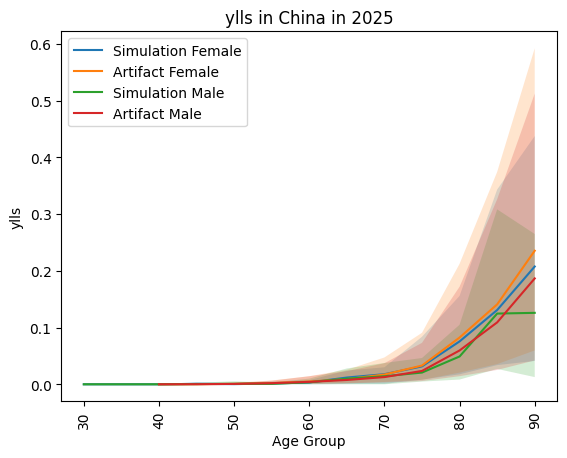

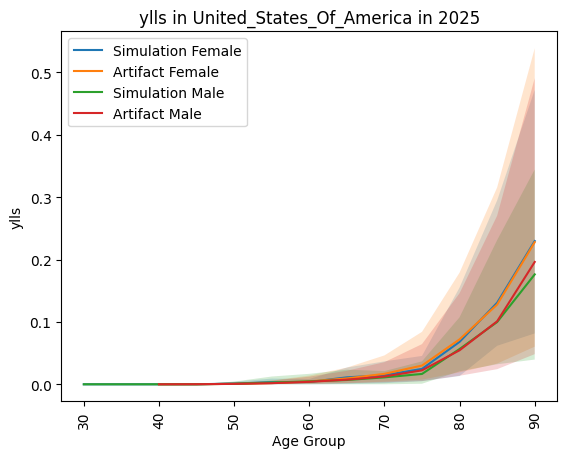

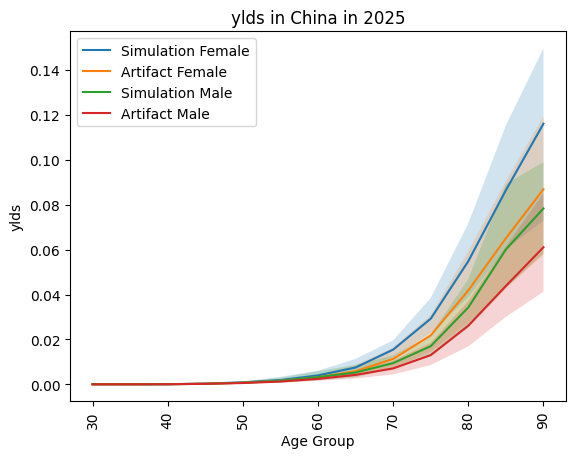

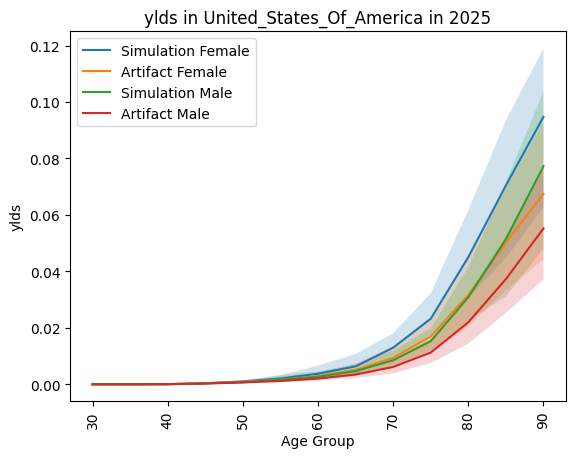

<Figure size 640x480 with 0 Axes>

In [67]:
for measure in ['ylls', 'ylds']:
    for location in sim_yll_yld.location.unique():
        for sex in sim_yll_yld.sex.unique():
            plot_data = sim_yll_yld.loc[(sim_yll_yld.location == location) & (sim_yll_yld.current_year == '2025') & (sim_yll_yld.sex == sex) & (sim_yll_yld.measure == measure)]
            art_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == measure)]

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['val'], label=f'Artifact {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"{measure} in {location} in 2025")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

YLDs look a little off here. Unclear why, perhaps an issue in calculating the average disability weight? 

## For comparison with model 2, calculate total “real world” Alzheimer’s population over time

In [114]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
    artifact = art.load('population.structure').reset_index()
    out = artifact.copy()
    out['value'] = 200_000 / out['value']
    out = out.rename(columns={'year_start': 'current_year','value': 'scale'})
    out['location'] = out.location.str.replace(' ', '_').str.title()
    scale = pd.concat([scale, out], ignore_index=True)
scale.head()

,location,sex,age_start,age_end,current_year,year_end,scale
0,United_States_Of_America,Female,0.000000,0.019178,2021,2022,5.832722
1,United_States_Of_America,Female,0.019178,0.076712,2021,2022,1.947040
2,United_States_Of_America,Female,0.076712,0.500000,2021,2022,0.263858
3,United_States_Of_America,Female,0.500000,1.000000,2021,2022,0.224577
4,United_States_Of_America,Female,1.000000,2.000000,2021,2022,0.112010


In [115]:
# Goal is prevalence at time t *times* sim pop at time t *divided by* scale factor 
# Don't the total person times cancel out here? I'm confused by this ask 

cols = ['input_draw','current_year','location','age_group','sex']

def calculate_real_world_pop():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[person_time_total.sub_entity == 'alzheimers_disease_and_other_dementias'].groupby(cols)['value'].sum().reset_index()
    infected = infected.merge(age_dictionary, on=['age_group'])
    infected = infected.loc[infected['age_group_id'].isin(age_group_ids)]
    infected = infected.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()

    real_world_pop = infected.merge(scale[['age_start','location','sex','scale']], on=['age_start','location','sex'])
    real_world_pop['mean'] = real_world_pop['mean'] / real_world_pop['scale']
    real_world_pop['2.5%'] = real_world_pop['2.5%'] / real_world_pop['scale']
    real_world_pop['97.5%'] = real_world_pop['97.5%'] / real_world_pop['scale']
    return real_world_pop

sim_real_pop = calculate_real_world_pop()
sim_real_pop

,current_year,location,age_group,sex,age_start,count,mean,std,min,2.5%,50%,97.5%,max,scale
0,2025,China,30_to_34,Female,30.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003421
1,2026,China,30_to_34,Female,30.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003421
2,2027,China,30_to_34,Female,30.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003421
3,2028,China,30_to_34,Female,30.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003421
4,2029,China,30_to_34,Female,30.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,2096,United_States_Of_America,90_to_94,Male,90.0,10.0,650.642632,47.673423,134.537988,439.148560,205.793292,865.384439,279.540041,0.318360
3948,2097,United_States_Of_America,90_to_94,Male,90.0,10.0,644.851490,50.014015,129.555099,418.566528,206.540726,871.371227,279.540041,0.318360
3949,2098,United_States_Of_America,90_to_94,Male,90.0,10.0,642.660247,49.303576,138.026010,442.005002,208.533881,872.427720,279.540041,0.318360
3950,2099,United_States_Of_America,90_to_94,Male,90.0,10.0,643.912386,53.030878,140.019165,447.561368,198.069815,935.465083,301.963039,0.318360


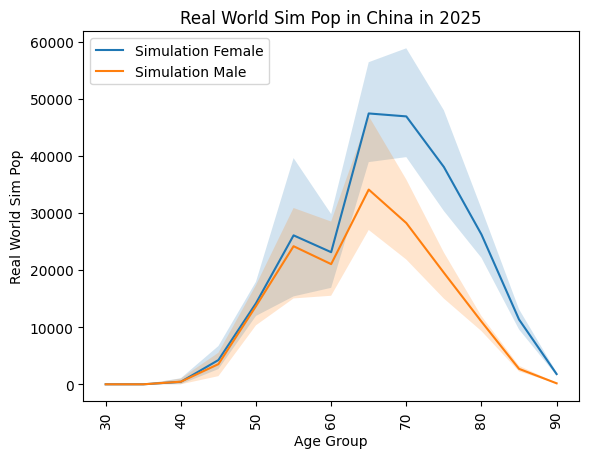

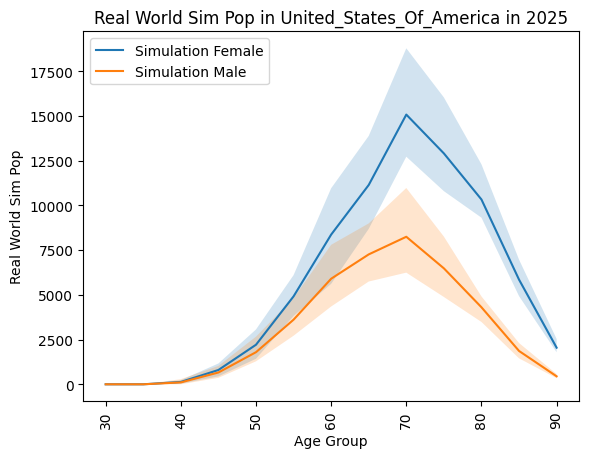

<Figure size 640x480 with 0 Axes>

In [117]:
for location in sim_real_pop.location.unique():
    for sex in sim_real_pop.sex.unique():
        plot_data = sim_real_pop.loc[(sim_real_pop.location == location) & (sim_real_pop.current_year == '2025') & (sim_real_pop.sex == sex)]

        plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
        plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

        plt.title(f"Real World Sim Pop in {location} in 2025")
        plt.tick_params(axis='x', labelrotation=90)
        plt.xlabel("Age Group")
        plt.ylabel(f"Real World Sim Pop")
        plt.legend()
    plt.figure()